# Feature Selection & Engineering

This notebook explores feature importance and performs feature selection to refine the dataset for modeling.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Configure plot style
sns.set(style="whitegrid")

In [42]:
# Load the cleaned dataset
df = pd.read_csv("../data/processed/clean_dataset.csv", parse_dates=["date"])
df.head()

,date,open,high,low,close,volume,dxy_close,oil_close,fedfunds,gs10,m2real,cpi,nfp,ppi,ema_21,ema_200,rsi_14,target
0,2016-01-04,-1.492593,-1.455997,-1.483192,-1.463562,-0.175159,0.083880,-1.655352,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.478729,-1.352997,-0.220203,1.796123
1,2016-01-05,-1.462683,-1.458433,-1.453351,-1.455477,-0.177236,0.185721,-1.698365,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.477311,-1.354477,0.087538,0.548533
2,2016-01-06,-1.447974,-1.428712,-1.437814,-1.422404,-0.178257,0.143447,-1.816113,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.472958,-1.355563,0.350051,1.118711
3,2016-01-07,-1.423458,-1.390464,-1.413153,-1.383697,-0.175874,-0.041019,-1.841921,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.465417,-1.356193,0.360552,1.630638
4,2016-01-08,-1.375652,-1.386323,-1.409700,-1.407950,-0.176691,0.020469,-1.852674,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.460807,-1.357096,0.786032,-1.629014


## Adding columns

We realized that our target has to be shift to next days' values. Also, we'll add next days' open price and remove close column

In [43]:
df["next_open"] = df["open"].shift(-1)
df["target"] = df["target"].shift(-1)
df = df.drop(columns=["close"], axis=1)
df.dropna(inplace=True)
df.head()

,date,open,high,low,volume,dxy_close,oil_close,fedfunds,gs10,m2real,cpi,nfp,ppi,ema_21,ema_200,rsi_14,target,next_open
0,2016-01-04,-1.492593,-1.455997,-1.483192,-0.175159,0.083880,-1.655352,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.478729,-1.352997,-0.220203,0.548533,-1.462683
1,2016-01-05,-1.462683,-1.458433,-1.453351,-0.177236,0.185721,-1.698365,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.477311,-1.354477,0.087538,1.118711,-1.447974
2,2016-01-06,-1.447974,-1.428712,-1.437814,-0.178257,0.143447,-1.816113,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.472958,-1.355563,0.350051,1.630638,-1.423458
3,2016-01-07,-1.423458,-1.390464,-1.413153,-0.175874,-0.041019,-1.841921,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.465417,-1.356193,0.360552,-1.629014,-1.375652
4,2016-01-08,-1.375652,-1.386323,-1.409700,-0.176691,0.020469,-1.852674,-0.882534,-0.413267,-1.447047,-1.309252,0.104853,-1.252882,-1.460807,-1.357096,0.786032,-0.832048,-1.388890


### --------------------------------------
### Just creating a full dataset for testing

df_full = df.drop(columns=['open'], axis=1)
df_full.to_csv("../data/processed/dataset_full.csv", index=False)

## Correlation Analysis
Plot a correlation heatmap to see how each feature relates to the target.

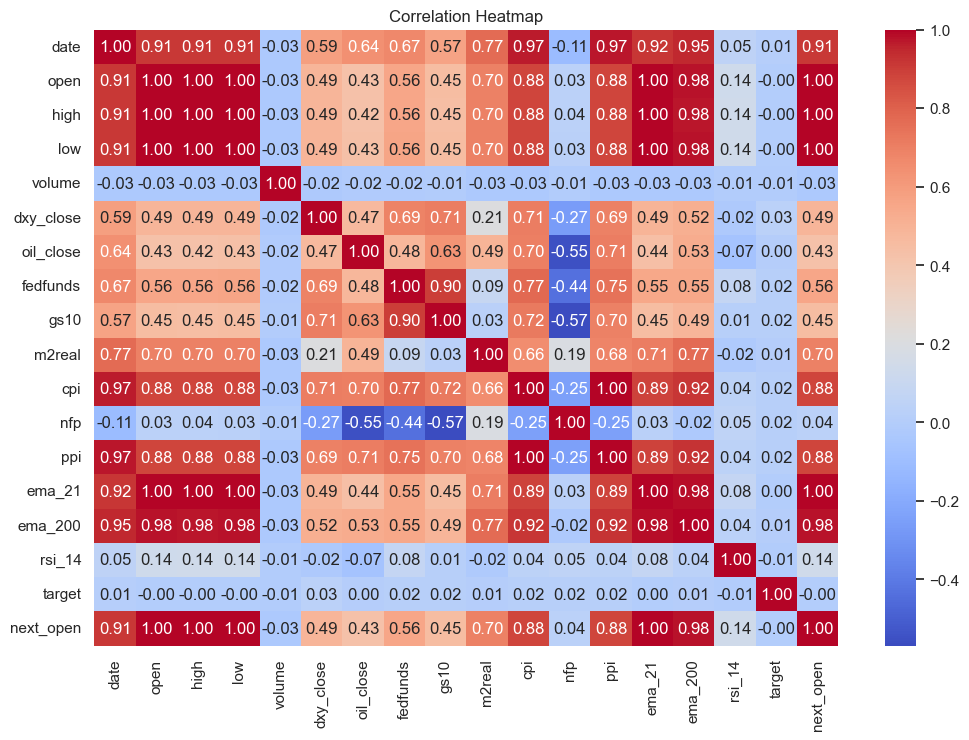

Correlation with target:
 target       1.000000
dxy_close    0.032804
fedfunds     0.018801
ppi          0.018438
cpi          0.017530
nfp          0.016510
gs10         0.015327
date         0.011612
ema_200      0.005781
m2real       0.005159
oil_close    0.003609
ema_21       0.000495
low         -0.002310
open        -0.002427
next_open   -0.002765
high        -0.003483
volume      -0.005257
rsi_14      -0.008281
Name: target, dtype: float64


In [45]:
# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Specifically, look at correlation with target variable
target_corr = corr["target"].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)

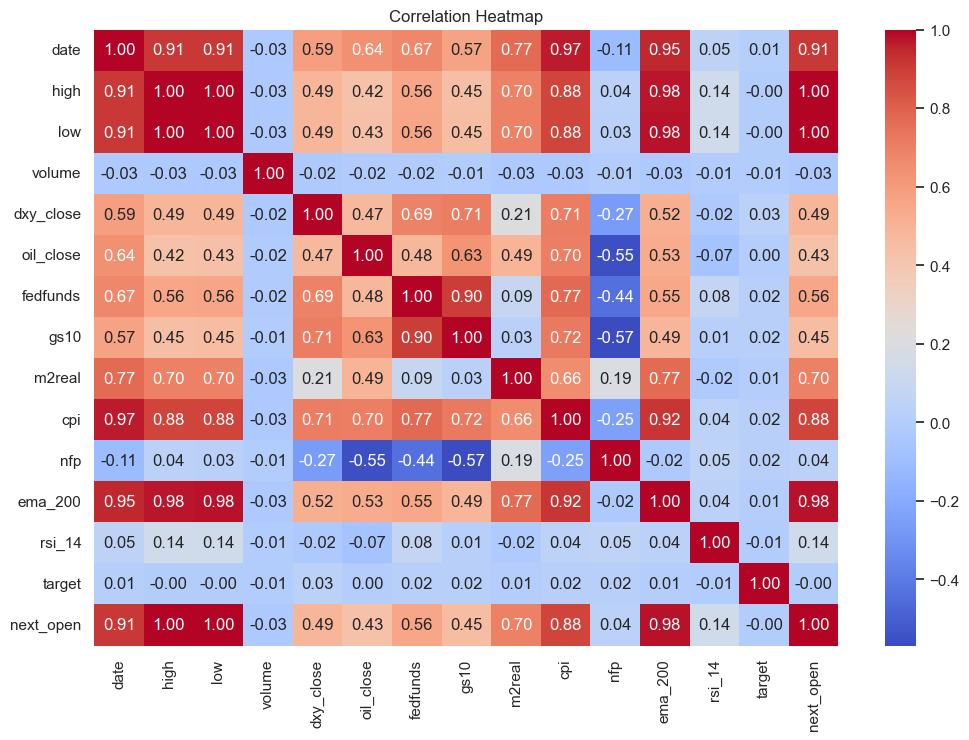

Correlation with target:
 target       1.000000
dxy_close    0.032804
fedfunds     0.018801
cpi          0.017530
nfp          0.016510
gs10         0.015327
date         0.011612
ema_200      0.005781
m2real       0.005159
oil_close    0.003609
low         -0.002310
next_open   -0.002765
high        -0.003483
volume      -0.005257
rsi_14      -0.008281
Name: target, dtype: float64


In [46]:
# Lets drop features with strong correlation between them

df = df.drop(columns=["open", "ema_21", 'ppi'])

# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Specifically, look at correlation with target variable
target_corr = corr["target"].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)

## Mutual Information
We'll compute the mutual information between each feature and the target to assess nonlinear relationships.

Mutual Information Scores:
volume       0.088142
ema_200      0.079268
m2real       0.072201
cpi          0.068603
gs10         0.043884
fedfunds     0.041034
nfp          0.040703
oil_close    0.032590
high         0.029742
low          0.026586
next_open    0.025268
dxy_close    0.000000
rsi_14       0.000000
dtype: float64


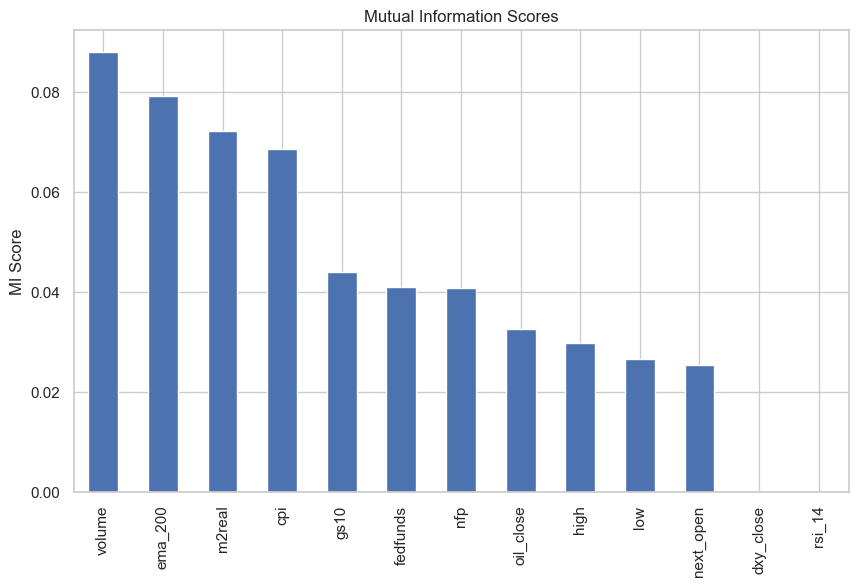

In [ ]:
# Identify feature columns
feature_cols = df.columns.difference(["date", "target"])
X = df[feature_cols].select_dtypes(include=[np.number])
y = df["target"]

# Compute mutual information scores
mi_scores = mutual_info_regression(X.fillna(0), y)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_scores_series)

# Plot MI scores
mi_scores_series.plot(kind="bar", figsize=(10, 6))
plt.title("Mutual Information Scores")
plt.ylabel("MI Score")
plt.show()

## Recursive Feature Elimination (RFE)
Using a linear regression model, we'll perform RFE to identify a subset of important features.

In [48]:
# Use RFE with a linear regression model
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=5)  # adjust the number of features as needed

# Fit RFE
rfe.fit(X.fillna(0), y)
rfe_features = pd.Series(rfe.support_, index=X.columns)
selected_features = rfe_features[rfe_features].index.tolist()
print("Selected features by RFE:", selected_features)

Selected features by RFE: ['cpi', 'ema_200', 'gs10', 'high', 'low']


## Feature importance using Random Forest
Random Forest can help detect important features

oil_close    0.166978
dxy_close    0.138713
volume       0.133943
rsi_14       0.130854
ema_200      0.101593
high         0.074093
low          0.074045
next_open    0.071667
gs10         0.031023
nfp          0.022866
m2real       0.021205
fedfunds     0.017122
cpi          0.015900
dtype: float64


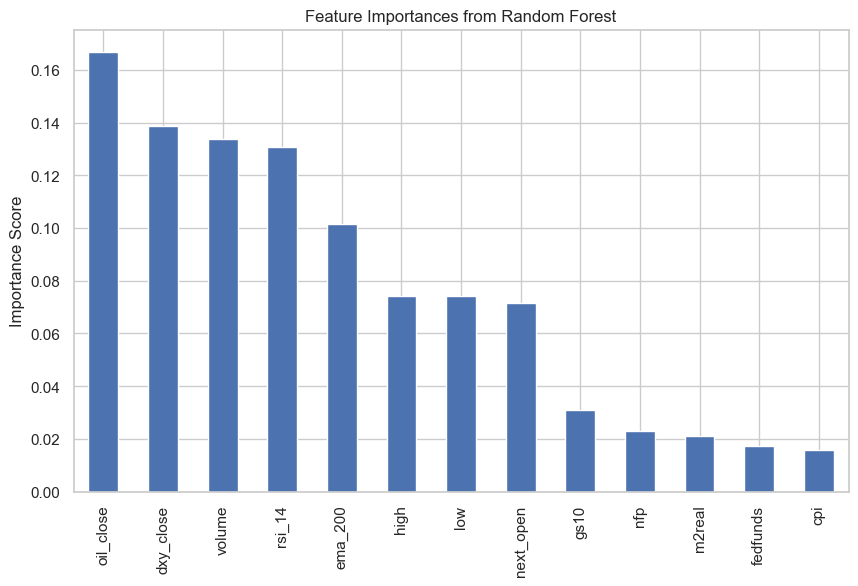

In [49]:
# Feature columns: all columns except 'Date' and 'target'
feature_cols = df.columns.difference(["date", "target"])
X = df[feature_cols]
y = df["target"]

# Initialize and fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances and create a sorted Series
importances = rf.feature_importances_
fi_series = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# Print and plot feature importance
print(fi_series)
fi_series.plot(kind="bar", figsize=(10, 6), title="Feature Importances from Random Forest")
plt.ylabel("Importance Score")
plt.show()

## Creating different sets of features
We'll proceed to create 3 different sets of features in order to compare their performance in the modelling phase and ultimately keep one for backtesting. Datasets are as following:
* RFE selected features
* Top 9 Mutual Information selected features (excluding date)
* Top 8 Feature Importance (Random Forest) selected features (excluding date)

In [50]:
# Dataset 1: RFE selected features
features_RFE = ['date', 'cpi', 'ema_200', 'high', 'low', 'next_open', 'target']
df_RFE = df[features_RFE].copy()
df_RFE.to_csv("../data/processed/dataset_RFE.csv", index=False)

# Dataset 2: MI based selected features
features_MI = ['date', 'ema_200', 'm2real', 'cpi', 'gs10', 'volume', 'low', 'high', 'next_open', 'fedfunds', 'target']
df_MI = df[features_MI].copy()
df_MI.to_csv("../data/processed/dataset_MI.csv", index=False)

# Dataset 3: RF based selected features
features_RF = ['date', 'oil_close', 'volume', 'dxy_close', 'rsi_14', 'ema_200', 'next_open', 'high', 'low', 'target']
df_RF = df[features_RF].copy()
df_RF.to_csv("../data/processed/dataset_RF.csv", index=False)